# **Densenet**

## Подготовка

In [1]:
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
import time
import matplotlib.pyplot as plt

In [2]:
def evaluate_accuracy(data_iter, net):
  acc_sum, n = 0, 0
  net.eval()
  for X, y in data_iter:
    X, y = X.to(device), y.to(device)
    acc_sum += (net(X).argmax(axis=1) == y).sum()
    n += y.shape[0]
  return acc_sum.item() / n

In [3]:
def train(net, train_iter, test_iter, trainer, num_epochs):
  net.to(device)
  loss_list = [] # список для значений функции потерь на трейне
  best_acc = 0 # переменная для лучшего значения accuracy
  loss = nn.CrossEntropyLoss(reduction = 'sum')
  net.train()
  for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

    for i, (X, y) in enumerate(train_iter):
      X, y = X.to(device), y.to(device)
      trainer.zero_grad()
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      trainer.step()
      train_l_sum += l.item()
      train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
      n += y.shape[0]

      if i % 100 == 0:
          print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")

    test_acc = evaluate_accuracy(test_iter, net.to(device))
    print(f'epoch {epoch + 1}, loss {train_l_sum / n}, train acc {train_acc_sum / n}, test acc {test_acc}, time {time.time() - start} sec')
    loss_list.append(train_l_sum / n)
    if test_acc > best_acc:
      best_acc = test_acc
  return loss_list, best_acc # будем возвращать список со значениями функции потерь на обучении и лучшую метрику на тесте

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    #lambda img: tv.transforms.functional.rotate(img, -90), # датасет почему-то был перевенутый и какой-то наклоненный, поэтому можно как вариант перевернуть все картинки,если будет плохая метрика
    #lambda img: tv.transforms.functional.hflip(img),
    tv.transforms.ToTensor()
])
train_dataset = tv.datasets.EMNIST('.', split='balanced', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='balanced', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|██████████| 561753746/561753746 [00:18<00:00, 30867870.99it/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [6]:
l = train_dataset.classes
l.sort()
print("No of classes: ",len(l))
print("List of all classes")
print(l)

No of classes:  47
List of all classes
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


In [7]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

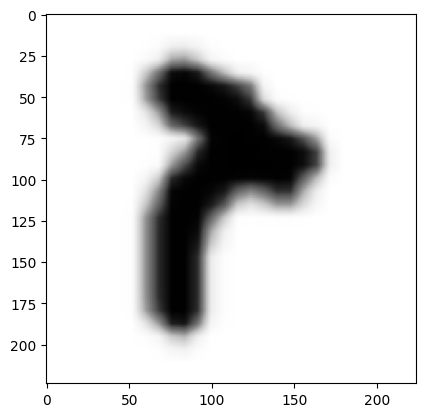

In [8]:
plt.imshow(train_dataset[0][0][0], cmap='Greys')

## Модель

In [9]:
model = tv.models.densenet161(pretrained=True) # самая тяжелая модель, с нуля не обучалась, поэтому загружена pretrained
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 135MB/s] 


In [10]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [11]:
model.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [12]:
for param in model.parameters():
  param.requires_grad = False

In [13]:
model.classifier = nn.Linear(in_features=2208, out_features=47, bias=True)

In [14]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.weight
	 classifier.bias


In [15]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [16]:
result_densenet = train(model, train_iter, test_iter, trainer, 10)

Step 0. time since epoch: 3.221. Train acc: 0.004. Train Loss: 3.903
Step 100. time since epoch: 228.318. Train acc: 0.482. Train Loss: 2.289
Step 200. time since epoch: 456.495. Train acc: 0.578. Train Loss: 1.806
Step 300. time since epoch: 684.984. Train acc: 0.627. Train Loss: 1.559
Step 400. time since epoch: 916.604. Train acc: 0.656. Train Loss: 1.407
epoch 1, loss 1.361690619854217, train acc 0.6643882978723404, test acc 0.7467553191489362, time 1134.1934020519257 sec
Step 0. time since epoch: 2.145. Train acc: 0.809. Train Loss: 0.817
Step 100. time since epoch: 216.486. Train acc: 0.776. Train Loss: 0.817
Step 200. time since epoch: 428.550. Train acc: 0.778. Train Loss: 0.799
Step 300. time since epoch: 640.227. Train acc: 0.782. Train Loss: 0.777
Step 400. time since epoch: 852.686. Train acc: 0.784. Train Loss: 0.763
epoch 2, loss 0.7568476708053697, train acc 0.785345744680851, test acc 0.7861170212765958, time 1062.0258944034576 sec
Step 0. time since epoch: 2.253. Train

In [17]:
result_densenet

([1.361690619854217,
  0.7568476708053697,
  0.6461211147714169,
  0.58996438222574,
  0.5547655776544665,
  0.5273119689048604,
  0.5084958423452174,
  0.49049052556355793,
  0.4772676985990917,
  0.4674639165486004],
 0.8135638297872341)